In [2]:
import argparse
import logging
import os
import sys

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

sys.path.append("..")
sys.path.append("../scripts/")
import superlayer.utils

from scripts import eval_net, train_net, get_args

from superlayer.models import UNet, TiedUNet, SUnet, SLNet
from superlayer.utils import BrainD, dice_coeff, one_hot, plot_img_array, plot_side_by_side

In [3]:
dir_img = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
dir_mask = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/asegs/'
dir_checkpoint_1 = 'checkpoints_1/'
dir_checkpoint_2 = 'checkpoints_2/'

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

In [4]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [5]:
target_label_numbers = [0,2,3,4,10,16,17,28,31,41,42,43,49,53,63]
val_percent = 0.1
batch_size = args.batchsize
lr = args.lr
img_scale = args.scale

dataset = BrainD(dir_img, dir_mask, label_numbers=target_label_numbers)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - 2 * n_val
n_test = n_val
train, val, test = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')

INFO: Creating dataset with 7329 examples


In [5]:
one_example = next(iter(train_loader))

image = one_example['image'][0]
mask = one_example['mask'][0]

print(image.shape)
print(mask.shape)

sq_img = image.squeeze(0).squeeze(0)
sq_msk = mask.squeeze(0).squeeze(0)

KeyboardInterrupt: 

In [ ]:
print(sq_img.shape)
plt.imshow(sq_img)

In [ ]:
print(sq_msk.shape)
plt.imshow(sq_msk)

In [ ]:
net1 = UNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{1} input channels\n'
             f'\t{15} output channels (classes)\n')

net1.to(device=device)
train_scores1, val_scores1, train_var_1, val_var_1 = train_net(net=net1,
                                                                epochs=1,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

In [ ]:
net2 = TiedUNet(in_channels=1, nshared=64, n_classes=15, enc_depth=4, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net2.in_channels} input channels\n'
             f'\t{net2.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net2.bilinear else "Transposed conv"} upscaling')

net2.to(device=device)
train_scores2, val_scores2, train_var_2, val_var_2 = train_net(net=net2,
                                                                epochs=1,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=2,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

In [6]:
enc_nf = [64, 64, 64, 64]
dec_nf = [64, 64, 64, 64]
net3 = SUnet(input_ch=1, out_ch=15, use_bn=True, enc_nf=enc_nf, dec_nf=dec_nf, ignore_last=False)

logging.info(f'Network:\n'
             f'\t{1} input channels\n'
             f'\t{15} output channels (classes)\n')

net3.to(device=device)
train_scores3, val_scores3, train_var_3, val_var_3 = train_net(net=net3,
                                                                epochs=5,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)

INFO: Starting training:
        Epochs:          5
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round: 100%|██████████| 91/91 [00:11<00:00,  7.34batch/s]
                                                                    INFO: Validation Dice Loss: 0.14752287966209454
Validation round: 100%|██████████| 91/91 [00:11<00:00,  8.51batch/s]
                                                                    INFO: Validation Dice Loss: 0.13668244651385716
Validation round:  32%|███▏      | 29/91 [00:04<00:08,  7.58batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00,  8.08batch/s]
                                                                    INFO: Validation Dice Loss: 0.1312291831760616
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.94batch/s]
                                                                    INFO: Validation Dice Loss: 0.13332653774337455
Validation round:  95%|█████████▍| 86/91 [00:10<00:00, 10.44batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.02batch/s]
                                                                    INFO: Validation Dice Loss: 0.1244628648836534
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  7.77batch/s]
                                                                    INFO: Validation Dice Loss: 0.1265288234412015
Validation round: 100%|██████████| 91/91 [00:10<00:00,  7.59batch/s]
                                                                    INFO: Validation Dice Loss: 0.1341269414994743
Validation round:  32%|███▏      | 29/91 [00:03<00:06,  9.45batch/s]


Validation round:  98%|█████████▊| 89/91 [00:10<00:00,  8.59batch/s]
                                                                    INFO: Validation Dice Loss: 0.1246655468757336
Epoch 1/5:  89%|████████▉ | 5865/6597 [02:40<00:19, 36.65img/s, loss (batch)=0.524]
INFO: Checkpoint 1 saved !
Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.03batch/s]
                                                                    INFO: Validation Dice Loss: 0.11894632532046391
Validation round:  85%|████████▍ | 77/91 [00:09<00:01, 10.40batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00, 10.73batch/s]
                                                                    INFO: Validation Dice Loss: 0.12001638826760617
Validation round: 100%|██████████| 91/91 [00:11<00:00,  8.87batch/s]
                                                                    INFO: Validation Dice Loss: 0.11858890492182511
Validation round: 100%|██████████| 91/91 [00:11<00:00,  9.13batch/s]
                                                                    INFO: Validation Dice Loss: 0.1196812541111485
Validation round:  25%|██▌       | 23/91 [00:03<00:08,  7.60batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.23batch/s]
                                                                    INFO: Validation Dice Loss: 0.11797965252464944
Validation round:  66%|██████▌   | 60/91 [00:07<00:03,  7.83batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00,  9.70batch/s]
                                                                    INFO: Validation Dice Loss: 0.12002249651557796
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.11batch/s]
                                                                    INFO: Validation Dice Loss: 0.11852501259072797
Epoch 2/5:  89%|████████▉ | 5865/6597 [02:39<00:19, 36.69img/s, loss (batch)=0.501]
INFO: Checkpoint 2 saved !
Validation round: 100%|██████████| 91/91 [00:11<00:00,  7.88batch/s]
                                                                    INFO: Validation Dice Loss: 0.1178269080899574
Validation round:   7%|▋         | 6/91 [00:02<01:14,  1.14batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00,  9.12batch/s]
                                                                    INFO: Validation Dice Loss: 0.11788643249771097
Validation round:  99%|█████████▉| 90/91 [00:11<00:00,  9.08batch/s]
                                                                    INFO: Validation Dice Loss: 0.11838680571252173
Validation round:  48%|████▊     | 44/91 [00:06<00:05,  7.91batch/s]


Validation round:  99%|█████████▉| 90/91 [00:11<00:00,  7.66batch/s]
                                                                    INFO: Validation Dice Loss: 0.11814195277926685
Validation round: 100%|██████████| 91/91 [00:11<00:00, 10.59batch/s]
                                                                    INFO: Validation Dice Loss: 0.11797561570183261
Validation round: 100%|██████████| 91/91 [00:11<00:00, 10.21batch/s]
                                                                    INFO: Validation Dice Loss: 0.11790232884359884


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.50batch/s]
                                                                    INFO: Validation Dice Loss: 0.11796115756362349
Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.44batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795953669390835
Epoch 3/5:  89%|████████▉ | 5865/6597 [02:40<00:20, 36.55img/s, loss (batch)=0.504]
INFO: Checkpoint 3 saved !
Validation round:  40%|███▉      | 36/91 [00:05<00:05,  9.55batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00,  8.55batch/s]
                                                                    INFO: Validation Dice Loss: 0.11796489570822034
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.79batch/s]
                                                                    INFO: Validation Dice Loss: 0.1179583109505884
Validation round:  93%|█████████▎| 85/91 [00:09<00:00, 10.58batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  7.95batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795869641579114
Validation round: 100%|██████████| 91/91 [00:10<00:00, 11.36batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795842680302294
Validation round: 100%|██████████| 91/91 [00:10<00:00, 11.26batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795875340045153
Validation round:  27%|██▋       | 25/91 [00:04<00:09,  7.30batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.44batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795759495798049
Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.20batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795755541259116
Validation round:  77%|███████▋  | 70/91 [00:08<00:01, 11.13batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.13batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795824905345728
Epoch 4/5:  89%|████████▉ | 5865/6597 [02:38<00:19, 37.08img/s, loss (batch)=0.534]
INFO: Checkpoint 4 saved !
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.99batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795985764199561
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  7.90batch/s]
                                                                    INFO: Validation Dice Loss: 0.11796001377669009
Validation round:   9%|▉         | 8/91 [00:01<00:48,  1.71batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 13.50batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795838930449642
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.76batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795778719933478
Validation round:  59%|█████▉    | 54/91 [00:07<00:04,  8.59batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00,  7.26batch/s]
                                                                    INFO: Validation Dice Loss: 0.11796036804770375
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.65batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795889692647117
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  7.64batch/s]
                                                                    INFO: Validation Dice Loss: 0.11796083784365392
Validation round:   3%|▎         | 3/91 [00:01<01:47,  1.23s/batch]


Validation round: 100%|██████████| 91/91 [00:10<00:00,  9.70batch/s]
                                                                    INFO: Validation Dice Loss: 0.11795969626733235
Epoch 5/5:  89%|████████▉ | 5865/6597 [02:38<00:19, 37.04img/s, loss (batch)=0.502]
INFO: Checkpoint 5 saved !


In [7]:
net4 = SLNet(input_ch=1, out_ch=15, use_bn=True, superblock_size=64, depth=4)

logging.info(f'Network:\n'
             f'\t{1} input channels\n'
             f'\t{15} output channels (classes)\n')

net4.to(device=device)
train_scores4, val_scores4, train_var_4, val_var_4 = train_net(net=net4,
                                                                epochs=5,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)

INFO: Starting training:
        Epochs:          5
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round:  99%|█████████▉| 90/91 [00:11<00:00,  8.00batch/s]
                                                                    INFO: Validation Dice Loss: 0.08045428123447922
Validation round: 100%|██████████| 91/91 [00:10<00:00,  7.63batch/s]
                                                                    INFO: Validation Dice Loss: 0.0802675703397164
Validation round:  32%|███▏      | 29/91 [00:04<00:06,  8.97batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.06batch/s]
                                                                    INFO: Validation Dice Loss: 0.08183599017806105
Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.95batch/s]
                                                                    INFO: Validation Dice Loss: 0.07594300388962358
Validation round:  95%|█████████▍| 86/91 [00:10<00:00, 10.30batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.10batch/s]
                                                                    INFO: Validation Dice Loss: 0.06975956973466245
Validation round:  99%|█████████▉| 90/91 [00:11<00:00,  9.60batch/s]
                                                                    INFO: Validation Dice Loss: 0.0699954730468792
Validation round: 100%|██████████| 91/91 [00:10<00:00,  9.84batch/s]
                                                                    INFO: Validation Dice Loss: 0.06957341665095025
Validation round:  35%|███▌      | 32/91 [00:04<00:05, 11.30batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.32batch/s]
                                                                    INFO: Validation Dice Loss: 0.0636874129483988
Epoch 1/5:  89%|████████▉ | 5865/6597 [02:36<00:19, 37.36img/s, loss (batch)=0.206]
INFO: Checkpoint 1 saved !
Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 11.23batch/s]
                                                                    INFO: Validation Dice Loss: 0.05250660248182632
Validation round:  95%|█████████▍| 86/91 [00:09<00:00, 11.77batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.30batch/s]
                                                                    INFO: Validation Dice Loss: 0.051606255900728835
Validation round: 100%|██████████| 91/91 [00:11<00:00, 12.30batch/s]
                                                                    INFO: Validation Dice Loss: 0.052209611368048324
Validation round: 100%|██████████| 91/91 [00:11<00:00,  8.84batch/s]
                                                                    INFO: Validation Dice Loss: 0.0512119485781743
Validation round:  41%|████      | 37/91 [00:05<00:06,  8.22batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  7.80batch/s]
                                                                    INFO: Validation Dice Loss: 0.060824805236124733
Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.60batch/s]
                                                                    INFO: Validation Dice Loss: 0.05656562139699747
Validation round:  96%|█████████▌| 87/91 [00:10<00:00, 10.87batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 12.17batch/s]
                                                                    INFO: Validation Dice Loss: 0.04800673123899397
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  7.33batch/s]
                                                                    INFO: Validation Dice Loss: 0.04691686816922911
Epoch 2/5:  89%|████████▉ | 5865/6597 [02:36<00:19, 37.45img/s, loss (batch)=0.175]
INFO: Checkpoint 2 saved !
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.84batch/s]
                                                                    INFO: Validation Dice Loss: 0.04497725033498073
Validation round:  37%|███▋      | 34/91 [00:05<00:07,  7.57batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.13batch/s]
                                                                    INFO: Validation Dice Loss: 0.04642540028134545
Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.25batch/s]
                                                                    INFO: Validation Dice Loss: 0.04594964067359547
Validation round:  81%|████████▏ | 74/91 [00:08<00:01,  8.54batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.34batch/s]
                                                                    INFO: Validation Dice Loss: 0.047008126319109736
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  7.47batch/s]
                                                                    INFO: Validation Dice Loss: 0.04413217420761402
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.38batch/s]
                                                                    INFO: Validation Dice Loss: 0.043476588205321805
Validation round:  25%|██▌       | 23/91 [00:03<00:08,  7.87batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 11.68batch/s]
                                                                    INFO: Validation Dice Loss: 0.043532324934398736
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.44batch/s]
                                                                    INFO: Validation Dice Loss: 0.04360372458512966
Epoch 3/5:  89%|████████▉ | 5865/6597 [02:36<00:19, 37.40img/s, loss (batch)=0.128]
INFO: Checkpoint 3 saved !
Validation round:  71%|███████▏  | 65/91 [00:07<00:02, 10.12batch/s]


Validation round:  99%|█████████▉| 90/91 [00:09<00:00, 12.97batch/s]
                                                                    INFO: Validation Dice Loss: 0.04328569753484412
Validation round: 100%|██████████| 91/91 [00:11<00:00,  8.89batch/s]
                                                                    INFO: Validation Dice Loss: 0.04357889581185121
Validation round:  99%|█████████▉| 90/91 [00:11<00:00,  9.67batch/s]
                                                                    INFO: Validation Dice Loss: 0.04397109077199475
Validation round:   8%|▊         | 7/91 [00:02<00:51,  1.63batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00,  7.07batch/s]
                                                                    INFO: Validation Dice Loss: 0.043719364145954884
Validation round: 100%|██████████| 91/91 [00:11<00:00,  9.63batch/s]
                                                                    INFO: Validation Dice Loss: 0.043034829854310216
Validation round:  63%|██████▎   | 57/91 [00:07<00:04,  7.69batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.15batch/s]
                                                                    INFO: Validation Dice Loss: 0.0431274930526922
Validation round: 100%|██████████| 91/91 [00:11<00:00, 10.07batch/s]
                                                                    INFO: Validation Dice Loss: 0.0430681980573214
Validation round: 100%|██████████| 91/91 [00:10<00:00,  9.55batch/s]
                                                                    INFO: Validation Dice Loss: 0.04309478737823256
Epoch 4/5:  89%|████████▉ | 5865/6597 [02:37<00:19, 37.31img/s, loss (batch)=0.158]
INFO: Checkpoint 4 saved !
Validation round:   9%|▉         | 8/91 [00:02<00:52,  1.59batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00, 11.09batch/s]
                                                                    INFO: Validation Dice Loss: 0.04313089739490342
Validation round:  98%|█████████▊| 89/91 [00:10<00:00,  7.20batch/s]
                                                                    INFO: Validation Dice Loss: 0.04315369199592989
Validation round:  49%|████▉     | 45/91 [00:06<00:04, 10.10batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.39batch/s]
                                                                    INFO: Validation Dice Loss: 0.04312326104103864
Validation round:  98%|█████████▊| 89/91 [00:10<00:00,  7.31batch/s]
                                                                    INFO: Validation Dice Loss: 0.043124956744057794
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.07batch/s]
                                                                    INFO: Validation Dice Loss: 0.04312041745736049
Validation round:   1%|          | 1/91 [00:01<02:30,  1.67s/batch]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  7.58batch/s]
                                                                    INFO: Validation Dice Loss: 0.04311928562410585
Validation round: 100%|██████████| 91/91 [00:10<00:00, 11.63batch/s]
                                                                    INFO: Validation Dice Loss: 0.043119533212630304
Validation round:  48%|████▊     | 44/91 [00:05<00:05,  9.38batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.92batch/s]
                                                                    INFO: Validation Dice Loss: 0.04311908380343364
Epoch 5/5:  89%|████████▉ | 5865/6597 [02:36<00:19, 37.54img/s, loss (batch)=0.151]
INFO: Checkpoint 5 saved !


In [ ]:
print("configuring plot one")
domain = len(train_scores1)
x_values = [i+1 for i in range(domain)]
plt.title("UNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores1, color="blue", label="train")
plt.plot(x_values, val_scores1, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [ ]:
print("configuring plot two")
domain = len(train_scores2)
x_values = [i+1 for i in range(domain)]
plt.title("SL-Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores2, color="blue", label="train")
plt.plot(x_values, val_scores2, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [ ]:
print("configuring plot three")
domain = len(train_scores3)
x_values = [i+1 for i in range(domain)]
plt.title("Simple Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores3, color="blue", label="train")
plt.plot(x_values, val_scores3, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

plt.subplot(1, 2, 1)

In [ ]:
print("configuring plot four")
domain = len(train_scores4)
x_values = [i+1 for i in range(domain)]
plt.title("Simple TiedNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores4, color="blue", label="train")
plt.plot(x_values, val_scores4, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

configuring combined plots


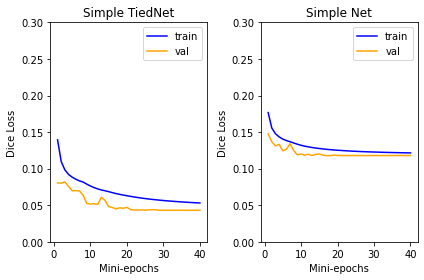

In [8]:
print("configuring combined plots")
domain = len(train_scores4)

x_values = [i+1 for i in range(domain)]
a1 = plt.subplot(1,2,1)
a1.set_ylim([0, 0.3])
plt.title("Simple TiedNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores4, color="blue", label="train")
plt.plot(x_values, val_scores4, color="orange", label="val")
plt.legend()

domain = len(train_scores3)
a2 = plt.subplot(1,2,2)
a2.set_ylim([0, 0.3])
plt.title("Simple Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores3, color="blue", label="train")
plt.plot(x_values, val_scores3, color="orange", label="val")
plt.legend()

plt.tight_layout()

plt.show()
plt.close()

In [ ]:
import math

# Create another simulation dataset for test
train_loader = DataLoader(train, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
val_loader = DataLoader(val, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

# Get the first batch
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

inputs_train = train_batch['image']
labels_train = train_batch['mask']

inputs_val = val_batch['image']
labels_val = val_batch['mask']

inputs_test = test_batch['image']
labels_test = test_batch['mask']

In [ ]:
net1.eval() 
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net1.eval() 
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = inputs_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net1.eval() 
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = labels_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net2.eval()
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
net4.eval()
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = labels_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net4(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])